# LQ Game Notebook
## Fengjun Yang, 2020
This notebook contains experiments designed to test and investigate the properties of Nash and quantal response equilibria in dynamic games

# Importing, bookkeeping etc.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import scipy.linalg as sla
import matplotlib.pyplot as plt

from utils import *
from lqgame import LQGame, LQGcontrol, MPCLQControl
from unicycle import Unicycle

# LQGame Solver Tests

## Sanity Check 0: Test Linear costs in state and control
Here we test our LQ game algorithm with linear costs in state and control. Specifically, we tune the Q and R matrix given how much offset we want in terms of the center of the quadratic costs. Given the offsets in x and u both produce expected behavior in the trajectories

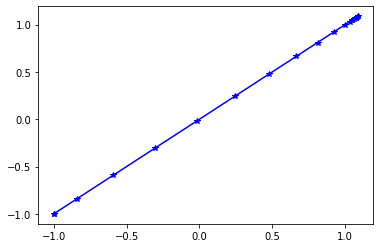

In [4]:
#############################################
N = 1    # Number of agents
T = 20    # Time horizon
dist_weight = 0 # How the cost from distance is weighted w.r.t. regularion cost
mult = 1
offsetx1, offsetx2 = 1, 1
offsetu1, offsetu2 = 0, 0
#############################################
# Generate the dynamics matrices A and B
xdim, udim = 4*N, 2
A, B = double_int_2D(N, T, coupled=True)
l = np.zeros((T, N, xdim))
lT = np.zeros((N, xdim))
r = np.zeros((T, N, N, udim))
# Generate the cost matrices Q, R, and QT
Q = np.zeros((N, xdim, xdim))
R = np.zeros((N,N,udim,udim))
QT = np.zeros((N, xdim, xdim))
dist_ind = np.arange(0, xdim, 4)
for i in range(N):
    weighted_ind = (i*4,i*4+2)
    Q[i] = np.eye(xdim)
    Q[i,1,1] = 0
    Q[i,3,3] = 0
    for j in range(N):
        R[i,j] = np.eye(udim)
    R[i,i] = np.eye(udim) * mult
QT = Q
#################################################
# Specify linear costs
l = np.tile(np.array([-offsetx1,0,-offsetx2,0]*N), (T,N,1))
lT = l[0]
r = np.tile(np.array([mult*offsetu1, mult*offsetu2]),(T,N,N,1))
##################################################
# Generate environment; solve for the eq
x0 = np.array([-1,0,-1,0])
g = LQGame(N, A, B, Q, R, QT, T, l, lT, r, x0)
P, alfa, sigma = g.solve()
cont = LQGcontrol(N, T, P, alfa, sigma)
# Plot Nash eq traj
traj = generate_traj(g, cont)
plot_double_int_2D_traj(traj, N)

## Sanity Check 1: iLQR Implementation
Here we test the correctness of our iLQGame implementation by applying the iterative method on an corrupted trajectory of an LQR problem. We show that our algorithm recovers the optimal trajectory with one iteration, as expected

opt cost	 35.7018754885576
corrupt cost	 35.7018754885576
improvement	 -19.104793958683654
improved cost	 35.7018754885576
ilqr cost = opt cost	 True


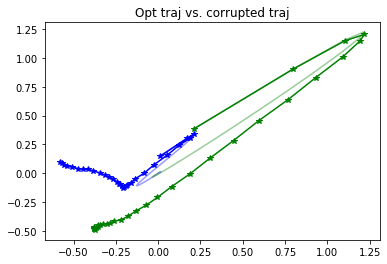

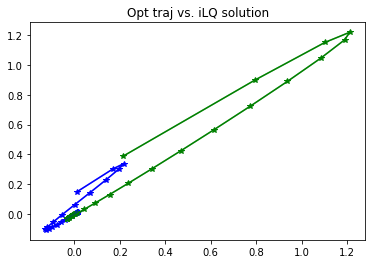

In [5]:
#############################################
# Parameters
T = 30
N = 2
#############################################
# Generate the dynamics matrices A and B
xdim, udim = 4*N, 2
A, B = double_int_2D(N, T, coupled=True)
l = np.zeros((T, N, xdim))
lT = np.zeros((N, xdim))
r = np.zeros((T, N, N, udim))
# Generate the cost matrices Q, R, and QT
Q = np.zeros((N, xdim, xdim))
R = np.zeros((N,N,udim,udim))
QT = np.zeros((N, xdim, xdim))
for i in range(N):
    weighted_ind = (i*4,i*4+1,i*4+2,i*4+3)
    Q[i] = np.eye(xdim)
    Q[i, weighted_ind, weighted_ind] = 10
    QT[i] = np.eye(xdim)    
    QT[i, weighted_ind, weighted_ind] = 10
    for j in range(N):
        R[i,j] = np.eye(udim)
    R[i,i] = np.eye(udim) * 10
x0 = np.random.random(xdim)
g = LQGame(N, A, B, Q, R, QT, T, l, lT, r, x0)
##############################################
# Solve the original LQ Game for optimal trajectory
solution_x, solution_u = g.generate_trajectory()
solution_cost = g.reward[0]
#############################################
# Corrupt the optimal trajectory
corruption = (np.random.random(solution_u.shape) - 1/2) / 5
corrupt_u = solution_u + corruption
cont = TrajControl(corrupt_u)
corrupt_x, _ = g.generate_trajectory(cont)
corrupt_cost = g.reward[0]

corrupt_cost = g.reward[0]
plot_double_int_2D_traj(corrupt_x, N)
plot_double_int_2D_traj(solution_x, N, True)
plt.title('Opt traj vs. corrupted traj')
############################################################
# Linearize around corrupted trajectory and solve for optimal
# offsets from the corrupted traj
xtraj = corrupt_x
utraj = corrupt_u
approx = g.linearize_traj(xtraj, utraj)
dx, du = approx.generate_trajectory()
utraj = utraj + du
control = TrajControl(utraj)
prev_cost = g.reward[0]
xtraj = generate_traj(g, control)

plt.figure()
plot_double_int_2D_traj(xtraj, N)
plot_double_int_2D_traj(solution_x, N, True)
plt.title('Opt traj vs. iLQ solution')
###########################################################
print('opt cost\t', solution_cost)
print('corrupt cost\t', g.reward[0])
print('improvement\t', approx.reward[0])
print('improved cost\t', g.reward[0])
print('ilqr cost = opt cost\t', solution_cost ==  g.reward[0])

# Tests to Further Intuition about QREq

## Sanity Check 0: Decoupled Dynamics + Decoupled Costs
This experiment is designed to serve as a basic sanity check for the implementation of the environment and the planning algorithm.
- Here, we consider a linear-quadratic game where the agents have *deterministic* and decoupled double-integrator dynamics. The quadratic cost coefficients are randomly sampled PD matrices. The initial conditions of the agents are also randomly initialized.
- We plot the trajectories under the equilibrium. The solid trajectories with scatter points represent the trajectories obtained by applying the deterministic policy under Nash. The trasparent trajectories are samples from applying the stochastic solution to the quantal response equilibrium.
- We observe that the agents converge to the origin. This is consistent with objective of the regulator problem.

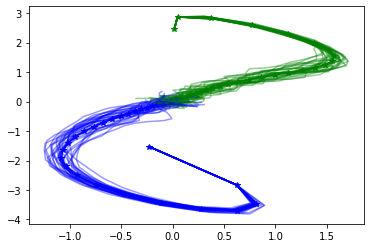

In [8]:
#############################################
N = 2     # Number of agents
T = 30    # Time horizon
#############################################
# Generate environment; solve for the eq
g = random_double_int_env(N, T)
x0 = g.x0
P, alfa, sigma = g.solve()
cont = LQGcontrol(N, T, P, alfa, sigma)
# Plot Nash eq traj
traj = generate_traj(g, cont)
plot_double_int_2D_traj(traj, N)

# Plot QReq traj
cont.stochastic = True
for i in range(30):
    traj = generate_traj(g, cont)
    plot_double_int_2D_traj(traj, N, True)

## Sanity Check 1: Decoupled LQ system with coupled cost
- Here, we consider a linear-quadratic game where the agents have decoupled double integrator dynamics. Their initial conditions are identical to the previous setup in sanity check 0.
- Compared to the previous setup, we also add in a cost for the L2 distance between every pair of agents
- We plot the trajectories under both equilibria. Again, note that the initial condition is identical to that of sanity check 0.

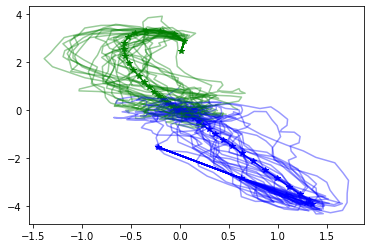

In [9]:
#############################################
N = 2    # Number of agents
T = 30    # Time horizon
dist_weight = -0.1 # How the cost from distance is weighted w.r.t. regularion cost
#############################################

# Generate the dynamics matrices A and B
xdim, udim = 4*N, 2
A, B = double_int_2D(N, T, coupled=True)
l = np.zeros((T, N, xdim))
lT = np.zeros((N, xdim))
r = np.zeros((T, N, N, udim))

# Generate the cost matrices Q, R, and QT
Q = np.zeros((N, xdim, xdim))
R = np.zeros((N,N,udim,udim))
QT = np.zeros((N, xdim, xdim))
dist_ind = np.arange(0, xdim, 4)
for i in range(N):
    weighted_ind = (i*4,i*4+2)
    Q[i] = np.eye(xdim) * 10
    Q[i, np.arange(0, xdim,2), np.arange(0,xdim,2)] = np.ones(N*2) * (1+dist_weight)
    Q[i, weighted_ind, weighted_ind] += N * dist_weight
    Q[i, weighted_ind[0], dist_ind] = -dist_weight
    Q[i, dist_ind, weighted_ind[0]] = -dist_weight
    Q[i, weighted_ind[0]+2, dist_ind+2] = -dist_weight
    Q[i, dist_ind+2, weighted_ind[0]+2] = -dist_weight
    Q[i, weighted_ind, weighted_ind] = (N-1)*dist_weight + 1
    for j in range(N):
        R[i,j] = np.eye(udim)
    R[i,i] = np.eye(udim)
QT = Q * 10

# Generate environment; solve for the eq
g = LQGame(N, A, B, Q, R, QT, T, l, lT, r, x0)
P, alfa, sigma = g.solve()
cont = LQGcontrol(N, T, P, alfa, sigma)
# Plot Nash eq traj
traj = generate_traj(g, cont)
plot_double_int_2D_traj(traj, N)

# Plot QReq traj
cont.stochastic = True
for i in range(30):
    traj = generate_traj(g, cont)
    plot_double_int_2D_traj(traj, N, True)

## Sanity Check 2: Coupled LQ system
This experiment is designed to serve as a basic sanity check for the implementation of the environment and the planning algorithm.
- Here, we consider a linear-quadratic game where the agents have *deterministic* but *coupled* dynamics. Their initial conditions are randomly generated.
- We assume that the acceleration control applied by agent i on herself also has a reduced effect (0.5x) in the same direction on the other agents. We let the control cost be the same for all agents. However, we weigh the state regulation cost of agent 1 higher for every agent
- We plot the trajectories under both equilibria.
- We observe that the NE trajectory of agent 1 (in blue) converges to the origin, which reflects the fact that all agents receive high penalty for the positional deviation of agent 1. We also observe that overall the trajectory in the QReq has higher variance than compared to the case when dynamics and rewards are decoupled.

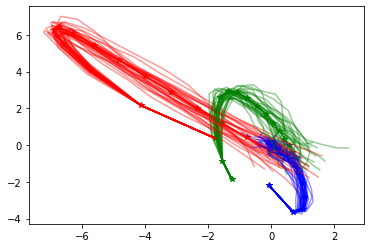

In [11]:
#############################################
N = 3     # Number of agents
T = 15    # Time horizon
#############################################

# Generate the dynamics matrices A and B
xdim, udim = 4*N, 2
A, B = double_int_2D(N, T, coupled=True)
l = np.zeros((T, N, xdim))
lT = np.zeros((N, xdim))
r = np.zeros((T, N, N, udim))

# Generate the cost matrices Q, R, and QT
Q = np.zeros((N, xdim, xdim))
R = np.zeros((N,N,udim,udim))
QT = np.zeros((N, xdim, xdim))
weighted_ind = (0,1,2,3)
for i in range(N):
    Q[i] = np.eye(xdim)
    Q[i, weighted_ind, weighted_ind] = 10
    QT[i] = np.eye(xdim)    
    QT[i, weighted_ind, weighted_ind] = 10
    for j in range(N):
        R[i,j] = np.eye(udim)

# Generate environment; solve for the eq
g = LQGame(N, A, B, Q, R, QT, T, l, lT, r)
P, alfa, sigma = g.solve()
cont = LQGcontrol(N, T, P, alfa, sigma)
# Plot Nash eq traj
traj = generate_traj(g, cont)
plot_double_int_2D_traj(traj, N)
# Plot QReq traj
cont.stochastic = True
for i in range(30):
    traj = generate_traj(g, cont)
    plot_double_int_2D_traj(traj, N, True)

## Sanity Check 3: Coupled LQ system
This experiment is designed to serve as a basic sanity check for the implementation of the environment and the planning algorithm.
- Here, we consider a linear-quadratic game where the agents have *deterministic* but *coupled* dynamics. Their initial conditions are randomly generated.
- We assume that the acceleration control applied by agent i on herself also has a reduced effect (0.5x) in the same direction on the other agents. For each agent, we weight the control and state cost of herself more heavily than those of other agents 
- We plot the trajectories under both equilibria.

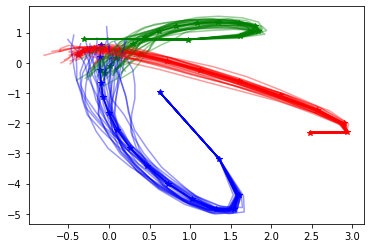

In [12]:
#############################################
N = 3     # Number of agents
T = 15    # Time horizon
#############################################

# Generate the dynamics matrices A and B
xdim, udim = 4*N, 2
A, B = double_int_2D(N, T, coupled=True)
l = np.zeros((T, N, xdim))
lT = np.zeros((N, xdim))
r = np.zeros((T, N, N, udim))

# Generate the cost matrices Q, R, and QT
Q = np.zeros((N, xdim, xdim))
R = np.zeros((N,N,udim,udim))
QT = np.zeros((N, xdim, xdim))
for i in range(N):
    weighted_ind = (i*4,i*4+1,i*4+2,i*4+3)
    Q[i] = np.eye(xdim)
    Q[i, weighted_ind, weighted_ind] = 10
    QT[i] = np.eye(xdim)    
    QT[i, weighted_ind, weighted_ind] = 10
    for j in range(N):
        R[i,j] = np.eye(udim)
    R[i,i] = np.eye(udim) * 10

# Generate environment; solve for the eq
g = LQGame(N, A, B, Q, R, QT, T, l, lT,r)
P, alfa, sigma = g.solve()
cont = LQGcontrol(N, T, P, alfa, sigma)
# Plot Nash eq traj
traj = generate_traj(g, cont)
plot_double_int_2D_traj(traj, N)
# Plot QReq traj
cont.stochastic = True
for i in range(30):
    traj = generate_traj(g, cont)
    plot_double_int_2D_traj(traj, N, True)

## Sanity Check 4: Model Predictive Control (LQ system, No noise)

[104861.84923987  90440.12418785  78976.6558976   70301.97022929
  92795.84839129]
[104974.22606359  90228.02455712  78575.7102565   69974.02934984
  92659.56466691]


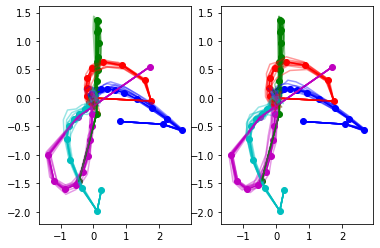

In [230]:
#############################################
N = 5     # Number of agents
T = 30    # Time horizon
#############################################
# Generate environment; solve for the eq
g = random_double_int_env(N, T)
P, alfa, sigma = g.solve()
cont = LQGcontrol(N, T, P, alfa, sigma)
#################Open-loop####################
# Plot Nash eq traj
plt.subplot(1,2,1)
traj = generate_traj(g, cont)
plot_double_int_2D_traj(traj, N)
# Plot QReq traj
cont.stochastic = True
avg_rwd = np.zeros(N)
for i in range(10):
    traj = generate_traj(g, cont)
    plot_double_int_2D_traj(traj, N, True)
    avg_rwd = avg_rwd + g.reward
print(avg_rwd)
#################MPC##########################
plt.subplot(1,2,2)
g.reset()
mpc = MPCLQControl(*g.get_params(), stochastic=False)
traj = generate_traj(g, mpc)
mpc.stochastic = True
plot_double_int_2D_traj(traj, N)
# Plot QReq traj
cont.stochastic = True
avg_rwd = np.zeros(N)
for i in range(10):
    traj = generate_traj(g, mpc)
    plot_double_int_2D_traj(traj, N, True)
    avg_rwd = avg_rwd + g.reward
print(avg_rwd)

## Sanity Check 5: Model Predictive Control (LQ system, With noise)

[120224.97426301 206972.43732426 143324.86426289]
[117624.10132492 204326.50002295 144489.75510839]


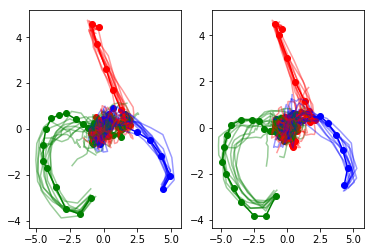

In [72]:
#############################################
N = 3     # Number of agents
T = 50    # Time horizon
#############################################
# Generate environment; solve for the eq
g = random_double_int_env(N, T)
g.noise_var=0.1
P, alfa, sigma = g.solve()
cont = LQGcontrol(N, T, P, alfa, sigma)
#################Open-loop####################
# Plot Nash eq traj
plt.subplot(1,2,1)
traj = generate_traj(g, cont)
plot_double_int_2D_traj(traj, N)
# Plot QReq traj
cont.stochastic = True
avg_rwd = np.zeros(N)
for i in range(10):
    traj= generate_traj(g, cont)
    plot_double_int_2D_traj(traj, N, True)
    avg_rwd = avg_rwd + g.reward
print(avg_rwd)
#################MPC##########################
plt.subplot(1,2,2)
mpc = MPCLQControl(*g.get_params(), stochastic=False)
traj = generate_traj(g, mpc)
plot_double_int_2D_traj(traj, N)
# Plot QReq traj
mpc.stochastic = True
avg_rwd = np.zeros(N)
for i in range(10):
    traj = generate_traj(g, mpc)
    plot_double_int_2D_traj(traj, N, True)
    avg_rwd = avg_rwd + g.reward
print(avg_rwd)

# Nonlinear Env: Unicycle

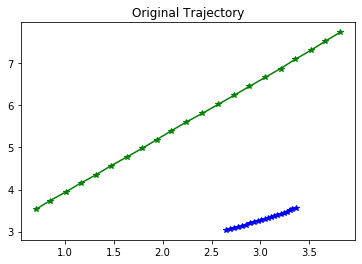

In [18]:
############################################
# Create env and generate random trajectory
############################################
# Parameters
x0 = np.array([-2, 1, 0, 0, 2, 1, 0, 0])
T = 20
N = 2
xdim, udim = 4*N, 2
x0 = np.random.random(xdim) * 5
############################################
# Construct an environment
l = np.zeros((T, N, xdim))
lT = np.zeros((N, xdim))
r = np.zeros((T, N, N, udim))
# Generate the cost matrices Q, R, and QT
Q = np.zeros((N, xdim, xdim))
R = np.zeros((N,N,udim,udim))
QT = np.zeros((N, xdim, xdim))
for i in range(N):
    weighted_ind = (i*4,i*4+1)
    Q[i] = np.eye(xdim)
    Q[i, weighted_ind, weighted_ind] = 100
    QT[i] = np.eye(xdim)
    QT[i, weighted_ind, weighted_ind] = 100
    for j in range(N):
        R[i,j] = np.eye(udim) * 10
    R[i,i] = np.eye(udim) * 10
############################################
uni = Unicycle(T, N, x0, Q, R, QT, l, lT, r)
uni.reset()
rand_cont = RandControl(N, 2)
zero_cont = ZeroControl(N, 2)
xtraj, utraj = uni.get_traj(rand_cont)
plot_unicycle_traj(xtraj, N)
_ = plt.title('Original Trajectory')

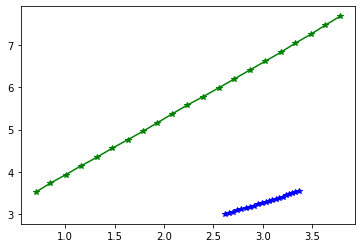

In [19]:
####################################################
# Manually improve the trajectory one time
####################################################
xtraj, utraj, _ = linearize_and_improve(uni, xtraj, utraj)
plot_unicycle_traj(xtraj, N)

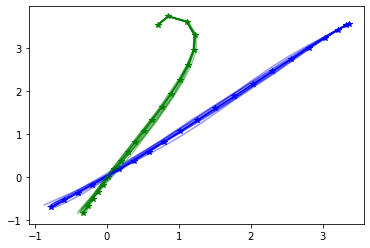

In [23]:
###################################################
# ILQ solutions
###################################################
# Plot the Nash trajectory
xtraj, utraj, cont = ilqgame(uni, xtraj, utraj)
plot_unicycle_traj(xtraj, N)
# Plot the QREq trajectory
for _ in range(10):
    gxtraj, gutraj = generate_nonlinear_traj(uni, xtraj, utraj, cont, True)
    plot_unicycle_traj(gxtraj, N, True)

## Non-convex cost

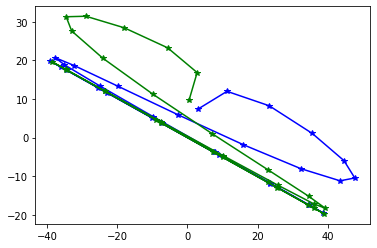

In [24]:
#############################################
N = 2    # Number of agents
T = 30    # Time horizon
##############################################
# There is a cost that accounts for the distance between the agents
# dist_weight > 0 means we want the agents to stay close
# dist_weight < 0 means we want the agents to stay apart
# Note that dist_weight < 0 can lead to a Q that is not PSD
# Specifically, d_w = 0.51 when Q starts to have negative eigvals
dist_weight = -10
#############################################

# Generate the dynamics matrices A and B
xdim, udim = 4*N, 2
A, B = double_int_2D(N, T, coupled=True)
l = np.zeros((T, N, xdim))
lT = np.zeros((N, xdim))
r = np.zeros((T, N, N, udim))

# Generate the cost matrices Q, R, and QT
Q = np.zeros((N, xdim, xdim))
R = np.zeros((N,N,udim,udim))
QT = np.zeros((N, xdim, xdim))
dist_ind = np.arange(0, xdim, 4)
for i in range(N):
    weighted_ind = (i*4,i*4+2)
    Q[i] = np.eye(xdim) * 10
    Q[i, np.arange(0, xdim,2), np.arange(0,xdim,2)] = np.ones(N*2) * (1+dist_weight)
    Q[i, weighted_ind, weighted_ind] += N * dist_weight
    Q[i, weighted_ind[0], dist_ind] = -dist_weight
    Q[i, dist_ind, weighted_ind[0]] = -dist_weight
    Q[i, weighted_ind[0]+2, dist_ind+2] = -dist_weight
    Q[i, dist_ind+2, weighted_ind[0]+2] = -dist_weight
    Q[i, weighted_ind, weighted_ind] = (N-1)*dist_weight + 1
    for j in range(N):
        R[i,j] = np.eye(udim)
    R[i,i] = np.eye(udim)
QT = Q * 10

# Generate environment; solve for the eq
x0 = np.random.random(xdim) * 10
g = LQGame(N, A, B, Q, R, QT, T, l, lT, r, x0)
P, alfa, sigma = g.solve()
cont = LQGcontrol(N, T, P, alfa, sigma)
# Plot Nash eq traj
xtraj, utraj = g.generate_trajectory(cont)
plot_double_int_2D_traj(xtraj, N)

# Plot QReq traj
#cont.stochastic = True
#for i in range(10):
    #traj = generate_traj(g, cont)
    #plot_double_int_2D_traj(traj, N, True)

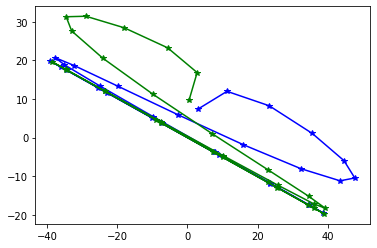

In [25]:
ilqx, ilqu, _ = ilqgame(g, xtraj, utraj)
plot_double_int_2D_traj(ilqx, N)

In [2723]:
np.linalg.eigvals(Q[0])

array([  1., -19.,   1., -19.,  10.,  10.,  10.,  10.])

In [27]:
np.linalg.eigvals(R[0,0] + B[0,0].T @ Q[0] @ B[0,0])

array([1.125, 1.125])